In [2]:
import pandas as pd
from random import randint, sample
import datetime as dt
import matplotlib.pyplot as plt

# Import SQL Alchemy
import sqlalchemy
from sqlalchemy.sql import func
from sqlalchemy.orm import Session\

# Import and establish Base for which classes will be constructed 
from sqlalchemy.ext.automap import automap_base
Base = automap_base()

In [3]:
engine = sqlalchemy.create_engine("sqlite:///sql/hawaii.sqlite", echo = False)
session = Session(bind = engine)

In [4]:
Base.prepare(engine, reflect = True)

In [5]:
Base.classes.keys()

['prcp_measurements', 'stations', 'temp_measurements']

In [6]:
conn = engine.connect()
conn.execute("select * from stations").fetchall()

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [7]:
Measurement = Base.classes.prcp_measurements
Station = Base.classes.stations
Temp_Measurement = Base.classes.temp_measurements

In [8]:
session = sqlalchemy.orm.Session(bind = engine)

In [9]:
for station in session.query(Station):
    print(station.station_id)

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [10]:
data_first_date = session.query(Measurement.date).order_by(Measurement.date).first()
data_first_date

('2010-01-01')

In [11]:
data_last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [12]:
trip_length = 8#randint(5,15)


In [13]:
delta = dt.datetime.strptime(data_last_date[0] , "%Y-%m-%d") - dt.datetime.strptime(data_first_date[0] , "%Y-%m-%d")
available_travel_days = delta.days - trip_length

In [47]:
trip_start_date_dt = dt.datetime.strptime(data_first_date[0] , "%Y-%m-%d")\
    + dt.timedelta(randint(365,available_travel_days))
trip_end_date_dt = trip_start_date_dt + dt.timedelta(trip_length+1)

trip_start_date = trip_start_date_dt.strftime("%Y-%m-%d")
trip_end_date = trip_end_date_dt.strftime("%Y-%m-%d")

In [15]:
#results = session.query(Measurement).

In [16]:
results = session.query(Measurement).filter(Measurement.date > trip_start_date).filter(Measurement.date < trip_end_date)
trip_prcp_data = {}
for result in results:
    if result.station_id not in trip_prcp_data:
        trip_prcp_data[result.measurement_id] = {"date": result.date, "station_id": result.station_id, "prcp": result.prcp}
    

In [17]:
results = session.query(Temp_Measurement).filter(Temp_Measurement.date > trip_start_date).filter(Temp_Measurement.date < trip_end_date)
trip_temp_data = {}
for result in results:
    if result.station_id not in trip_temp_data:
        trip_temp_data[result.measurement_id] = {"date": result.date, "station_id": result.station_id, "temp": result.tobs}
    

In [18]:
df = pd.DataFrame(trip_prcp_data).T.groupby("station_id").count()
stations = []
for i in df.index:
    if df.loc[i,"date"] == trip_length:
        stations.append(i)
print(stations)
print(df)

['USC00511918', 'USC00513117', 'USC00519281']
             date  prcp
station_id             
USC00511918     8     8
USC00513117     8     8
USC00514830     6     6
USC00516128     6     6
USC00517948     5     5
USC00518838     5     5
USC00519281     8     8
USC00519397     7     7
USC00519523     7     7


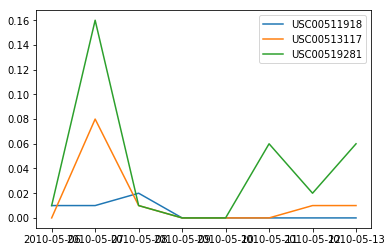

In [19]:
prcp_df = pd.DataFrame(trip_prcp_data).T

prcp_df = prcp_df[prcp_df.station_id.isin(stations)]
for station, dat in prcp_df.groupby("station_id"):
    plt.plot(dat['date'], dat['prcp'], label = station)
plt.legend(loc = 'best')
plt.show()

In [20]:
pd.DataFrame(trip_temp_data).T.groupby("station_id").count()

,date,temp
station_id,,
USC00511918,8,8
USC00513117,8,8
USC00514830,7,7
USC00516128,7,7
USC00517948,6,6
USC00518838,6,6
USC00519281,8,8
USC00519397,7,7
USC00519523,7,7


In [21]:
temp_df = pd.DataFrame(trip_temp_data).T.groupby("station_id").count()
stations = []
for i in temp_df.index:
    if temp_df.loc[i,"date"] == trip_length:
        stations.append(i)
print(stations)
print(temp_df)

['USC00511918', 'USC00513117', 'USC00519281']
             date  temp
station_id             
USC00511918     8     8
USC00513117     8     8
USC00514830     7     7
USC00516128     7     7
USC00517948     6     6
USC00518838     6     6
USC00519281     8     8
USC00519397     7     7
USC00519523     7     7


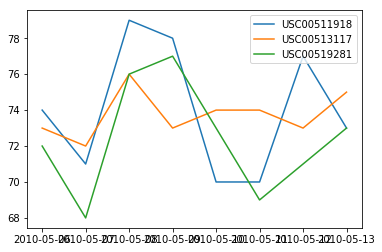

In [22]:
temp_df = pd.DataFrame(trip_temp_data).T

temp_df = temp_df[temp_df.station_id.isin(stations)]
for station, dat in temp_df.groupby("station_id"):
    plt.plot(dat['date'], dat['temp'], label = station)
plt.legend(loc = 'best')
plt.show()

In [40]:
def calc_temps(start_date, end_date):

    temps = session.query(func.max(Temp_Measurement.tobs).label("max temp"),\
                         func.min(Temp_Measurement.tobs).label("min temp"),\
                         func.avg(Temp_Measurement.tobs).label("mean temp"))\
        .filter(Temp_Measurement.date >= start_date)\
        .filter(Temp_Measurement.date <= end_date).all()[0]
    
    return temps


In [48]:
start_date_1ya_dt = trip_start_date_dt - dt.timedelta(365)
start_date_1ya = start_date_1ya_dt.strftime("%Y-%m-%d")
end_date_1ya_dt = trip_end_date_dt - dt.timedelta(365)
end_date_1ya = end_date_1ya_dt.strftime("%Y-%m-%d")

(max_temp, min_temp, avg_temp) = calc_temps(start_date_1ya, end_date_1ya)

In [62]:
plt.bar(0 ,height = avg_temp,tick_label = "")
plt.errorbar(0,avg_temp, yerr = [max_temp-avg_temp, min_temp-avg_temp] )
plt.show()

ValueError: err must be [ scalar | N, Nx1 or 2xN array-like ]